In [36]:
import sys
import os

sys.path.append(r'D:\Study\CS179\pyGM')
import pyGM as gm
import numpy as np
import matplotlib.pyplot as plt
from load_data import *
%matplotlib inline     

In [37]:
ver_map = load_counter()
playerid, nplayers, playerA, playerB, raceA, raceB, wins, counters = load_data(ver_map)
playerid_val, nplayers_val, nplays_val, nwins_val, games_val = load_valid_data(playerid, ver_map)
assert playerid == playerid_val

In [3]:
print('summary: ')
print('# players', nplayers)
print('# games', len(wins))
print('player A', playerA[:10])
print('player B', playerB[:10])
print('wins', wins[:10])

summary: 
# players 999
# games 19008
player A [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
player B [2, 3, 4, 5, 6, 7, 8, 9, 10, 9]
wins [0, 0, 0, 0, 1, 1, 1, 0, 0, 1]


### calculate the original skill level

In [21]:
def gm_model(nplayers, playerA, playerB, wins):
    nlevels = 10   # let's say 10 discrete skill levels
    scale = 0.8     # this scales how skill difference translates to win probability

    X = [None]*nplayers
    for i in range(nplayers):
        X[i] = gm.Var(i, nlevels)   

    Pwin = np.zeros( (nlevels,nlevels) )
    for i in range(nlevels):
        for j in range(nlevels):
            diff = i-j                   # find the advantage of Pi over Pj, then 
            Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage
            Pwin[i,j] += 1e-8

    # before any games, uniform belief over skill levels for each player:
    factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

    # Now add the information from each game:
    for P1,P2,win in zip(playerA, playerB, wins):
    #     P1,P2,win = g[0],g[1],g[2]
        if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
        P1, P2 = P1 -1, P2 -1
        factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )

    model = gm.GraphModel(factors)
    model.makeMinimal()

    from pyGM.messagepass import LBP, NMF
    #     lnZ,bel = LBP(model, maxIter=10, verbose=True)   # loopy BP
    lnZ,bel = NMF(model, maxIter=10, verbose=True)  # Mean field
    
    return bel,X,Pwin

In [22]:
bel,X, Pwin = gm_model(nplayers, playerA, playerB, wins)

Iter 0: -28612.0153185495
Iter 1: -9901.50751968022
Iter 2: -9069.357547929008
Iter 3: -8985.570175272194
Iter 4: -8951.05006899707
Iter 5: -8945.724970392788
Iter 6: -8943.485356260082
Iter 7: -8938.889951384426
Iter 8: -8935.263574693605
Iter 9: -8934.049969004747
Iter 10: -8933.804487389001


In [35]:
nlevels = 10   # let's say 10 discrete skill levels
scale = 0.8  
original_skill = bel[998].table.dot(np.arange(nlevels))
original_skill

1.1912739888610555

original skill level of the last player: 1.1912739888610562

### prune out the last player
now we will prune out all the matchs of the last player

In [41]:
def prune_one_player(playerA, playerB, wins, nprune):
    P1_new, P2_new, wins_new = [], [], []
    prune_match = []
    for P1, P2, win in zip(playerA, playerB, wins):
        if(P1 != nprune and P2 != nprune):
            P1_new.append(P1)
            P2_new.append(P2)
            wins_new.append(win)
        else:
            prune_match.append((P1, P2, win))
    
    return P1_new, P2_new, wins_new, prune_match

In [42]:
prune_player = 998
original_skill = bel[prune_player].table.dot(np.arange(nlevels))
P1_new, P2_new, wins_new, prune_match = prune_one_player(playerA, playerB, wins, prune_player)

In [43]:
print(len(P1_new), len(playerA))
print(len(wins_new), len(wins))
print(len(P2_new), len(playerB))

18994 19008
18994 19008
18994 19008


### iteration to add match

Iter 0: -28592.446914407283
Iter 1: -9892.379669024964
Iter 2: -9061.949004375894
Iter 3: -8977.615150698497
Iter 4: -8943.019400754807
Iter 5: -8937.307017185347
Iter 6: -8935.050100009936
Iter 7: -8930.573106026693
Iter 8: -8926.857805607318
Iter 9: -8925.611690070564
Iter 10: -8925.350802529536
new estimate skill:  1.191056226108947
loss:  0.00021776275210849683
Iter 0: -28593.952175847688
Iter 1: -9893.084695006595
Iter 2: -9062.343924219034
Iter 3: -8977.986862045524
Iter 4: -8943.359033088627
Iter 5: -8937.638768836794
Iter 6: -8935.371344208394
Iter 7: -8930.829145127058
Iter 8: -8927.167439620824
Iter 9: -8925.937206865912
Iter 10: -8925.683213847858
new estimate skill:  1.19114366019219
loss:  0.00013032866886542038
Iter 0: -28595.45743819092
Iter 1: -9894.016775207487
Iter 2: -9062.78470054973
Iter 3: -8978.66240000708
Iter 4: -8943.93282006765
Iter 5: -8938.610412487873
Iter 6: -8936.400777051369
Iter 7: -8931.975584724409
Iter 8: -8928.203022588727
Iter 9: -8926.93634461952

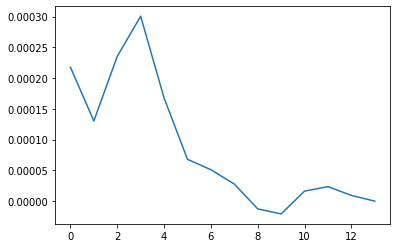

In [44]:
losses = []

original_skill = bel[998].table.dot(np.arange(nlevels))
for i in range(len(prune_match)):
    pA, pB, win = prune_match[i]
    P1_new.append(pA)
    P2_new.append(pB)
    wins_new.append(win)
    bel_,X_, _ = gm_model(nplayers, P1_new, P2_new, wins_new)
    new_skill = bel_[prune_player].table.dot(np.arange(nlevels))
    print('new estimate skill: ', new_skill)
    print("loss: ", original_skill - new_skill)
    losses.append(original_skill - new_skill)
    
plt.plot([i for i in range(len(prune_match))], losses)

### evaluation

In [19]:
def prediction_loss(bel, X, nplayers, nplays, nwins, games):
    
    loss = 0.
    binary_loss = 0.
    for i in range(nplayers):
        for j in range(i+1, nplayers):
            if nplays[i, j] == 0:
                continue
            prob = nwins[i,j] / nplays[i,j]
            prob_hat = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
            loss += np.abs(prob_hat - prob)
            binary_loss += np.logical_xor(prob_hat >= 0.5, prob >= 0.5)
    
    loss /= (nplays > 0).sum()/2
    binary_loss /= (nplays > 0).sum()/2
    
    return loss, binary_loss

In [20]:
skill = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]
loss, binary_loss = prediction_loss(bel, X, nplayers_val, nplays_val, nwins_val, games_val)

NameError: name 'Pwin' is not defined

In [18]:
loss, binary_loss

(0.2243461753568686, 0.15777106411547498)